## Implement and apply a Two layer neural network classifier with Keras

### MNIST and Fashion-MNIST dataset
The original [MNIST dataset](http://yann.lecun.com/exdb/mnist/) contains a lot of handwritten digits. Members of the AI/ML/Data Science community love this dataset and use it as a benchmark to validate their algorithms. In fact, MNIST is often the first dataset researchers try. *"If it doesn't work on **MNIST**, it won't work at all"*, they said. *"Well, if it does work on MNIST, it may still fail on others."*  
Here are some good reasons for using [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist):  
- MNIST is too easy. Convolutional nets can achieve 99.7% on MNIST. Classic machine learning algorithms can also achieve 97% easily. Check out our side-by-side benchmark for Fashion-MNIST vs. MNIST, and read "Most pairs of MNIST digits can be distinguished pretty well by just one pixel."
- MNIST is overused. In this April 2017 Twitter thread, Google Brain research scientist and deep learning expert Ian Goodfellow calls for people to move away from MNIST.
- MNIST can not represent modern CV tasks, as noted in this April 2017 Twitter thread, deep learning expert/Keras author François Chollet.


# Task 1:
Find Fashion MNIST on the internet and save it as `./input`

## Import packages

In [127]:
#!/usr/bin/env python3
 
##########################################################
# Copyright (c) Jesper Vang <jesper_vang@me.com>         #
# Created on 4 Aug 2021                                  #
# Version:	0.0.1                                        #
# What:  						                         #
##########################################################

# ploting and EDA
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# packages
import pandas as pd
import numpy as np
import os
import sklearn
import tensorflow as tf
# import keras
from keras.datasets import fashion_mnist

from sklearn.metrics import accuracy_score, confusion_matrix


print(f"Matplotlib Version: {matplotlib.__version__}")
print(f"Seaborn Version: {sns.__version__}")


print(f"Pandas Version: {pd.__version__}")
print(f"Numpy Version: {np.__version__}")
print(f"Scikit-learn Version: {sklearn.__version__}")
print(f"Tensorflow Version: {tf.__version__}")
# print(f"Keras Version: {keras.__version__}")

np.set_printoptions(precision=4)

%matplotlib inline

#plt.rcParams["figure.figsize"] = (10, 8)

Matplotlib Version: 3.2.2
Seaborn Version: 0.11.1
Pandas Version: 1.1.5
Numpy Version: 1.19.5
Scikit-learn Version: 0.22.2.post1
Tensorflow Version: 2.5.0


## Load the datasets
We haven't use the CSV file because we want to load the dataset using Numpy.  
**Notice:** If you use the `mnist_reader.py` codes from  [GitHub repository](https://github.com/zalandoresearch/fashion-mnist/blob/master/utils/mnist_reader.py), it might doesn't work. Because the `.gz` file has been unpacked.

### skipping dataload with numpy

We split our training data into train and validate datasets, in order to train our model and validate it using the validation data set to avoid overfitting before testing the model on the test datasets which is as real-world data for our model.

In [128]:
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()


In [129]:
print(f'X_train_full shape: {str(X_train_full.shape)}')
print(f'y_train_full shape: {str(y_train_full.shape)}')
print(f'X_test shape: {str(X_test.shape)}')
print(f'y_test shape: {str(y_test.shape)}')
print(f'Number of training examples: {str(y_train_full.shape[0])}')
print(f'Number of testing examples:{str(y_test.shape[0])}')

X_train_full shape: (60000, 28, 28)
y_train_full shape: (60000,)
X_test shape: (10000, 28, 28)
y_test shape: (10000,)
Number of training examples: 60000
Number of testing examples:10000


Note that the dataset is already split into a training set and a test set, but there is no validation set, so we’ll create one now

## Further split into Validation and Preproces
Additionally, since we are going to train the neural network using Gradient Descent, we must scale the input features. For simplicity, we’ll scale the pixel intensities down to the 0–1 range by dividing them by 255.0 (this also converts them to floats):

In [130]:
# Split the data into train / validation / test
X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

print (f"Number of validation examples: X_valid {str(X_valid.shape)}")
print (f"Number of training examples: X_train {str(X_train.shape)}")
print (f"Number of testing examples: X_test {str(X_test.shape)}")

Number of validation examples: X_valid (5000, 28, 28)
Number of training examples: X_train (55000, 28, 28)
Number of testing examples: X_test (10000, 28, 28)


When loading MNIST or Fashion MNIST using Keras rather than Scikit-Learn, one important difference is that every image is represented as a 28 × 28 array rather than a 1D array of size 784. Moreover, the pixel intensities are represented as integers (from 0 to 255) rather than floats (from 0.0 to 255.0). Let’s take a look at the shape and data type of the training set:

In [131]:
print(X_train_full.shape)
print(X_train_full.dtype)

(60000, 28, 28)
uint8


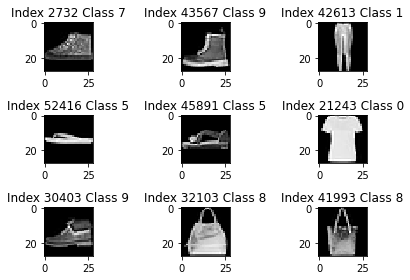

In [132]:
# random check with nine training examples
np.random.seed(0);
indices = list(np.random.randint(y_train.shape[0],size=9))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(X_train[indices[i]].reshape(28,28), cmap='gray', interpolation='none')
    plt.title(f"Index {indices[i]} Class {y_train[indices[i]]}")
    plt.tight_layout()

| 0           | 1       | 2        | 3     | 4    | 5     | 6     | 7       | 8    | 9          |
| ----------- | ------- | -------- | ----- | ---- | ----- | ----- | ------- | ---- | ---------- |
| T-shirt/top | Trouser | Pullover | Dress | Coat | Sanda | Shirt | Sneaker | Bag  | Ankle boot |


In [133]:
print("Feature Values: \nFrom " + str(np.min(X_train)) + " to " + str(np.max(X_train)))
print("Data type: " + str(X_train.dtype))
print("\nLabel Values: ")
print(set(list(y_train)))
print("Data type: " + str(y_train.dtype))

Feature Values: 
From 0.0 to 1.0
Data type: float64

Label Values: 
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Data type: uint8


## Add callback function to stop the training at when a accuracy is reached
fit() method accepts a callbacks argument that lets you specify a list of objects that Keras will call at the start and end of training, each epoch and before and after processing each batch.

In [134]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.96):
      print("\nReached 96% accuracy so cancelling training!")
      self.model.stop_training = True

## Initialize the neural network with Keras

In [135]:
# Simple classification MLP with two hidden layers:
callbacks = myCallback()
model = tf.keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

## Train your network

In [136]:
model.compile(loss="sparse_categorical_crossentropy",
        optimizer="adam",
        metrics=["accuracy"])

In [137]:
history = model.fit(X_train, y_train, epochs=50, callbacks=[callbacks], validation_data=(X_valid, y_valid))

Epoch 1/40
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4833 - accuracy: 0.8267 - val_loss: 0.3706 - val_accuracy: 0.8654
Epoch 2/40
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3649 - accuracy: 0.8664 - val_loss: 0.3306 - val_accuracy: 0.8836
Epoch 3/40
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3295 - accuracy: 0.8767 - val_loss: 0.3142 - val_accuracy: 0.8868
Epoch 4/40
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3046 - accuracy: 0.8871 - val_loss: 0.3481 - val_accuracy: 0.8708
Epoch 5/40
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2851 - accuracy: 0.8936 - val_loss: 0.3027 - val_accuracy: 0.8884
Epoch 6/40
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2706 - accuracy: 0.8975 - val_loss: 0.3401 - val_accuracy: 0.8756
Epoch 7/40
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2567 - accuracy: 0.9026 - val_loss: 0.3215 - val_accuracy:

In [138]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_12 (ModuleWra (None, 784)               0         
_________________________________________________________________
module_wrapper_13 (ModuleWra (None, 300)               235500    
_________________________________________________________________
module_wrapper_14 (ModuleWra (None, 100)               30100     
_________________________________________________________________
module_wrapper_15 (ModuleWra (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


## Print the training vs validation curves



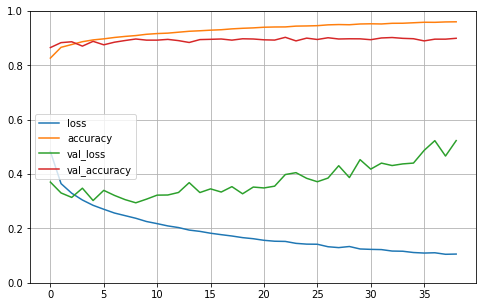

In [139]:
pd.DataFrame(history.history).plot(figsize=(8, 5)) 
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1] 
plt.show()

## Caclulate the Accuracy and F1 metric

In [140]:
from sklearn.metrics import accuracy_score


y_pred_nn = np.argmax(model.predict(X_test), axis=-1)
perf = accuracy_score(y_test, y_pred_nn)
print(f"Accuracy score: {perf}")

Accuracy score: 0.8714


In [141]:
evaluation = model.evaluate(X_test, y_test)
print(f'Test Accuracy : {evaluation[1]:.3f}')

313/313 [==============================] - 1s 2ms/step - loss: 116.8662 - accuracy: 0.8714
Test Accuracy : 0.871


With the model trained, you can use it to make predictions about some images.

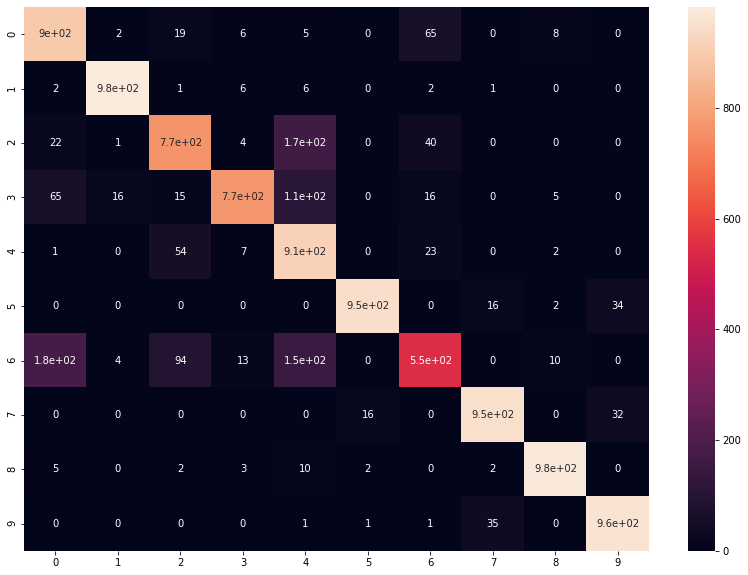

In [142]:
# get the predictions for the test data and pass to confusion_matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_nn)
plt.figure(figsize = (14,10))
sns.heatmap(cm, annot=True)
# Sum the diagonal element to get the total true correct values

In [143]:
from sklearn.metrics import classification_report

num_classes = 10
target_names = [f"Class {i}" for i in range(num_classes)]

print(classification_report(y_test, predicted_classes, target_names = target_names))

              precision    recall  f1-score   support

     Class 0       0.82      0.84      0.83      1000
     Class 1       0.98      0.98      0.98      1000
     Class 2       0.84      0.69      0.76      1000
     Class 3       0.94      0.82      0.88      1000
     Class 4       0.60      0.94      0.73      1000
     Class 5       0.99      0.90      0.95      1000
     Class 6       0.74      0.52      0.61      1000
     Class 7       0.94      0.94      0.94      1000
     Class 8       0.97      0.97      0.97      1000
     Class 9       0.90      0.98      0.94      1000

    accuracy                           0.86     10000
   macro avg       0.87      0.86      0.86     10000
weighted avg       0.87      0.86      0.86     10000

